In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, LSTM, TextVectorization, Dropout, StringLookup
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import keras

2025-05-11 16:40:48.789331: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 16:40:49.136773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746970849.234765   66906 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746970849.270702   66906 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746970849.521092   66906 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
df = pd.read_csv('Reviews.csv')

In [4]:
df = df.drop(columns=["Id", "HelpfulnessNumerator", "HelpfulnessDenominator"])

In [5]:
df

,ProductId,UserId,ProfileName,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [6]:
df = df.drop_duplicates(subset=["UserId", "ProductId"], keep="first").reset_index(drop=True)

In [7]:
df

,ProductId,UserId,ProfileName,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...
560799,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
560800,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
560801,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
560802,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [8]:
def filter_sparse_data(df, user_col="UserId", item_col="ProductId", min_user=5, min_item=5, max_iter=10):
    for i in range(max_iter):
        initial_shape = df.shape[0]

        # Filter users
        user_counts = df[user_col].value_counts()
        df = df[df[user_col].isin(user_counts[user_counts >= min_user].index)]

        # Filter items
        item_counts = df[item_col].value_counts()
        df = df[df[item_col].isin(item_counts[item_counts >= min_item].index)]

        # Break if no more rows are dropped
        if df.shape[0] == initial_shape:
            print(f"Stopped at iteration {i+1} with {df.shape[0]} rows.")
            break

    return df


In [9]:
df_filtered = filter_sparse_data(df, min_user=10, min_item=10)

Stopped at iteration 7 with 64945 rows.


In [10]:
df_filtered.reset_index(drop=True, inplace=True)

In [11]:
user_cat = pd.Categorical(df_filtered["UserId"])
item_cat = pd.Categorical(df_filtered["ProductId"])

df_filtered["user"] = user_cat.codes
df_filtered["item"] = item_cat.codes

user_mapping = dict(enumerate(user_cat.categories))
item_mapping = dict(enumerate(item_cat.categories))

In [12]:
df_filtered

,ProductId,UserId,ProfileName,Score,Time,Summary,Text,user,item
0,B000G6RYNE,A2NO1TXXS9T0EE,BruteNStones,4,1335398400,Hard,"Great if you are cutting back on fat, they do ...",1807,168
1,B000G6RYNE,A1IRN1M05TPOVT,"Sharon M. Helfand ""Scrapper""",5,1334620800,Kettle potato chips: Fully loaded baked potato,I have never met a Kettle brand chip I did not...,588,168
2,B000G6RYNE,ARONI7W0W677H,Peter N,5,1334275200,"Fresh, Lightly-Spiced, Crunchy Kettle Chips. G...",After buying bags one at a time (at a hefty ma...,3905,168
3,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,4,1334016000,glad to find them in 1 oz size,"I buy mostly for vending, so the size of the b...",1023,168
4,B000G6RYNE,A1ELZC3WXWILX2,B. Carter,5,1333670400,a slight taste of jalapeno,one of the best chips that you can buy...and i...,459,168
...,...,...,...,...,...,...,...,...,...
64940,B0030VJ8YU,A2QV1V06YJSQKQ,Renee Frank,5,1280188800,Baby loved it!,I bought this for my grandson. I used it for ...,1904,626
64941,B0030VJ8YU,A20P8VC55KPPCT,FL Mom,5,1274486400,These pouches are great!,These pouches are so easy and convenient. They...,1102,626
64942,B0030VJ8YU,AECQLWLETPUFZ,Tamara Irving,5,1274572800,perfect portions,This is a perfect portion and very simple to u...,3486,626
64943,B0030VJ8YU,AM4BBGZL4JY77,Pilar G. Vargas,5,1322524800,Yummy chicken,"My baby LOVES his chicken, and he prefers it i...",3728,626


In [13]:
X = df_filtered[['user', 'item', 'Text']]
y = df_filtered['Score'].astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
train_user_input = tf.convert_to_tensor(X_train['user'].values, dtype=tf.int32)
train_item_input = tf.convert_to_tensor(X_train['item'].values, dtype=tf.int32)
train_text_input = tf.convert_to_tensor(X_train['Text'].astype(str).tolist(), dtype=tf.string)

test_user = tf.convert_to_tensor(X_test['user'].values, dtype=tf.int32)
test_item = tf.convert_to_tensor(X_test['item'].values, dtype=tf.int32)
test_text = tf.convert_to_tensor(X_test['Text'].astype(str).tolist(), dtype=tf.string)

y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

I0000 00:00:1746970867.342362   66906 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [24]:
keras.utils.clear_session()

In [25]:
text_vec = TextVectorization(output_sequence_length=128, max_tokens=10000)
text_ds = tf.data.Dataset.from_tensor_slices(train_text_input).batch(32)
text_vec.adapt(text_ds)

2025-05-11 16:41:58.181064: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
num_users = df_filtered["user"].nunique()
num_items = df_filtered["item"].nunique()

In [27]:
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')
text_input = Input(shape=(1,), dtype=tf.string, name='text_input')

In [28]:
import math

user_embedding = Embedding(input_dim=num_users, output_dim=int(math.sqrt(num_users)), name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=int(math.sqrt(num_items)), name='item_embedding')(item_input)

user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

In [29]:
x = text_vec(text_input)
x = Embedding(input_dim=10000, output_dim=128)(x)
x = LSTM(128)(x)
review_vec = x

In [30]:
combined = Concatenate()([user_vec, item_vec, review_vec])
x = Dense(128, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1)(x)

model = Model(inputs=[user_input, item_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 128)       │          0 │ text_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 64)     │    266,688 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 32)     │     34,752 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │  1,280,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     28,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,750,145 (6.68 MB)

 Trainable params: 1,750,145 (6.68 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(
    [train_user_input, train_item_input, train_text_input],
    y_train_tensor,
    validation_split = 0.3,
    epochs=10,
    batch_size=64,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 2.7686 - mae: 1.2505 - val_loss: 0.6518 - val_mae: 0.6042
Epoch 2/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.8200 - mae: 0.7033 - val_loss: 0.5039 - val_mae: 0.4875
Epoch 3/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.6610 - mae: 0.6250 - val_loss: 0.4899 - val_mae: 0.4551
Epoch 4/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.5681 - mae: 0.5728 - val_loss: 0.4538 - val_mae: 0.4419
Epoch 5/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.4866 - mae: 0.5256 - val_loss: 0.4192 - val_mae: 0.4164
Epoch 6/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.4122 - mae: 0.4876 - val_loss: 0.3543 - val_mae: 0.3945
Epoch 7/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.3102 - mae: 0.4265 - val_loss: 0.3135 - val_mae: 0.3572
Epoch 8/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.2469 - mae: 0.3815 - val_loss: 0.2829 - val_mae: 0.3169
Epoch 9/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 

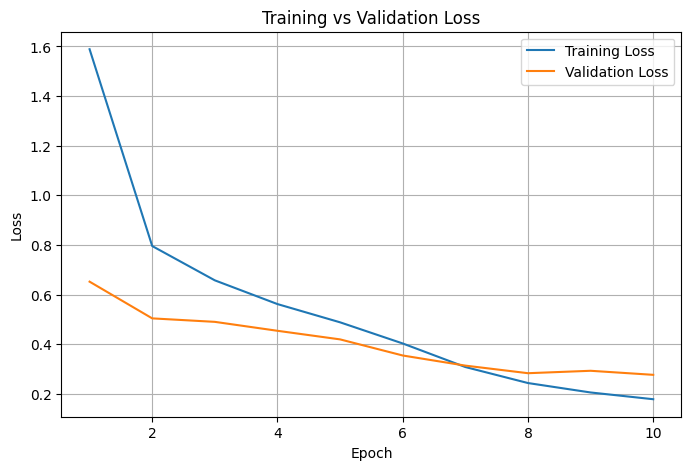

In [33]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
model.evaluate([test_user, test_item, test_text], y_test_tensor)

406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2628 - mae: 0.2841


[0.2642922103404999, 0.28122425079345703]

In [35]:
def recommend_for_user(user_id_str, model, df, user_cat, item_cat, text_placeholder="placeholder", top_n=10):
    user_mapping = dict(enumerate(user_cat.categories))
    item_mapping = dict(enumerate(item_cat.categories))
    user_inverse_mapping = {v: k for k, v in user_mapping.items()}
    
    if user_id_str not in user_inverse_mapping:
        raise ValueError(f"User '{user_id_str}' not found.")

    user_code = user_inverse_mapping[user_id_str]

    all_items = set(df["item"].unique())
    seen_items = set(df[df["user"] == user_code]["item"].unique())
    candidate_items = list(all_items - seen_items)

    user_data = tf.convert_to_tensor([user_code] * len(candidate_items), dtype=tf.int32)
    item_data = tf.convert_to_tensor(candidate_items, dtype=tf.int32)
    text_data = tf.convert_to_tensor([text_placeholder] * len(candidate_items), dtype=tf.string)

    predictions = model.predict(
        [user_data, item_data, text_data],
        verbose=0
    ).flatten()

    top_indices = np.argsort(predictions)[::-1][:top_n]
    top_item_codes = [candidate_items[i] for i in top_indices]
    top_scores = [predictions[i] for i in top_indices]

    top_product_ids = [item_mapping[code] for code in top_item_codes]

    return list(zip(top_product_ids, top_scores))

In [36]:
def show_user_history(user_id_str, df, user_cat, item_cat, max_items=10):
    user_mapping = dict(enumerate(user_cat.categories))
    user_inverse_mapping = {v: k for k, v in user_mapping.items()}

    if user_id_str not in user_inverse_mapping:
        raise ValueError(f"User '{user_id_str}' not found in training data.")

    user_code = user_inverse_mapping[user_id_str]

    user_data = df[df["user"] == user_code].copy()
    user_data = user_data.sort_values(by="Score", ascending=False).head(max_items)

    results = []
    for _, row in user_data.iterrows():
        results.append({
            "ProductId": row["ProductId"],
            "Score": row["Score"],
            "Summary": row.get("Summary", ""),
            "Text": row.get("Text", "")
        })

    return results


In [37]:
def get_reviews_for_product(product_id, df, max_reviews=5):
    product_reviews = df[df["ProductId"] == product_id].copy()
    
    if product_reviews.empty:
        return f"No reviews found for product: {product_id}"
    
    product_reviews = product_reviews.sort_values(by="Score", ascending=False).head(max_reviews)

    results = []
    for _, row in product_reviews.iterrows():
        results.append({
            "UserId": row.get("UserId", ""),
            "Score": row["Score"],
            "Summary": row.get("Summary", ""),
            "Text": row.get("Text", "")
        })

    return results

In [41]:
user_id = "A3A15L96IYUO6V"

history = show_user_history(user_id, df_filtered, user_cat, item_cat, max_items=10)

print(f"🧾 Review history for user {user_id}:\n")
for i, item in enumerate(history, 1):
    print(f"{i}. {item['ProductId']} — Score: {item['Score']}")
    print(f"   Summary: {item['Summary']}")
    print(f"   Text: {item['Text'][:150]}...\n")

🧾 Review history for user A3A15L96IYUO6V:

1. B005IW4WFY — Score: 5
   Summary: Delicious whole grain goodness
   Text: Healthy grains seem to be in the news recently and cereal bars, granola and other whole grain foods claim to be tasty and good for you.  The people at...

2. B001EO6E0Q — Score: 5
   Summary: Italian Garden Wow
   Text: Homemade dressings has a hit with Italian Garden because it is so versatile.  The directions say use it for salad dressings many of which I have made ...

3. B008RWUHA6 — Score: 5
   Summary: Delicious whole grain goodness
   Text: Healthy grains seem to be in the news recently and cereal bars, granola and other whole grain foods claim to be tasty and good for you.  The people at...

4. B003YBLF2E — Score: 5
   Summary: Surprisingly good
   Text: I wasn't expecting a whole lot out of a "ready to eat" meal, but this GoPicnic combination was a pleasant surprise. There was enough stuff to actually...

5. B008RWUKXK — Score: 5
   Summary: Delicious whole g

In [39]:
recommendations = recommend_for_user(
    user_id_str="A3A15L96IYUO6V",
    model=model,
    df=df_filtered,
    user_cat=user_cat,
    item_cat=item_cat,
    text_placeholder="I might like this product",
    top_n=10
)

for pid, score in recommendations:
    print(f"Product: {pid} — Predicted Score: {score:.2f}")

Product: B001CWX7EG — Predicted Score: 4.44
Product: B007GYQ6LA — Predicted Score: 4.40
Product: B000NMJWZO — Predicted Score: 4.39
Product: B000HDK0DC — Predicted Score: 4.38
Product: B000EVKHQM — Predicted Score: 4.33
Product: B000KEPBBY — Predicted Score: 4.31
Product: B001CWSKFC — Predicted Score: 4.29
Product: B000H7LVKY — Predicted Score: 4.29
Product: B007L3NVKU — Predicted Score: 4.29
Product: B002N7DSNE — Predicted Score: 4.29


In [40]:
product_id = "B001CWX7EG"

reviews = get_reviews_for_product(product_id, df_filtered, max_reviews=5)

print(f"📝 Reviews for product {product_id}:\n")
for i, review in enumerate(reviews, 1):
    print(f"{i}. Score: {review['Score']} by {review['UserId']}")
    print(f"   Summary: {review['Summary']}")
    print(f"   Text: {review['Text'][:200]}...\n") 

📝 Reviews for product B001CWX7EG:

1. Score: 5 by A17RZUM0T1OA8K
   Summary: LOVE, LOVE, LOVE 'EM!!!
   Text: LOVE THEM!!<br /><br />The Glutino GF Pretzel Sticks are my very favorite.  They are great for dipping.  Any pieces that are broken I save to put on top of a bowl/cup of soup.  They stand up well to c...

2. Score: 5 by A2XL6TZM34HFV3
   Summary: I like them much more than regular pretzels
   Text: My son's celiac so we buy these pretzels by the case.  I was never a big fan of pretzels but I eat these all the time.  They''ve got just the right amount of crunch and salt, and they're good for dipp...

3. Score: 5 by AJEA4B0RKCWVC
   Summary: Great Snack for Gluten free kids
   Text: Sometimes it is hard to find a quick snack for Gluten free kids.  These pretzels are the best of all the GF pretzels we have tried. We leave a bag at my sons preschool for snack time. He loves them....

4. Score: 5 by AK8LOFYRZJJW0
   Summary: Just As Good As Wheat Pretzels.
   Text: My kids were pret

In [42]:
model.save("recommendation_system.keras")